In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

In [2]:
def visualize_heatmaps(heatmaps):
    """
    Visualizes heatmaps
    
    heatmaps: tensor of shape (num_queries, H, W)
    """

    # Assuming heatmaps is a tensor of shape (num_queries, H, W)
    num_queries, H, W = heatmaps.shape

    # Define the number of rows and columns for your subplot array. 
    # We take the square root of the number of queries to roughly equalize the number of rows and columns.
    num_rows = int(num_queries**0.5)
    num_cols = num_queries // num_rows + (num_queries % num_rows != 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,10))

    for i, ax in enumerate(axes.flatten()):
        if i < num_queries:
            ax.imshow(heatmaps[i].cpu().numpy(), cmap='hot', interpolation='bilinear')
            ax.axis('off')
        else:
            fig.delaxes(ax)  # delete extra axes

    plt.tight_layout()
    plt.show()

In [3]:
# load the BoQ model with a ResNet-50 backbone.
vpr_model = torch.hub.load("amaralibey/bag-of-queries", "get_trained_boq", backbone_name="resnet50", output_dim=16384)

im_size = (384, ) # resize one side to 384, the other side will be resized to keep the aspect ratio. Note that when using ResNet-50 in BoQ the output feature maps of the backbone are 1/16 of the input image size. We will need this later to resize the heatmaps to the input image size.
def input_transform(image_size=im_size):
    return T.Compose([
        T.ToTensor(),
        T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC, antialias=True),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

Using cache found in /home/amar/.cache/torch/hub/amaralibey_bag-of-queries_main


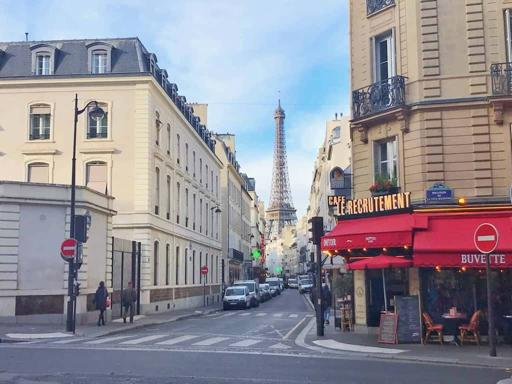

In [4]:
# use PIL to read an input image
pil_img = Image.open("paris_street.jpg")
pil_img

In [5]:
# apply transformations
transform = input_transform()
torch_img = transform(pil_img).unsqueeze(0) # unsqueeze to add batch dimension
output, attentions = vpr_model(torch_img) # output is the descriptor, attentions is a list attention maps (each list contain the attention maps for a single BoQ block)

In [6]:
print(f'Descriptor dimension: {output.shape[1]}-dim.')
print(f'There are {len(attentions)} BoQ blocks. Each block has {attentions[0].shape[1]} learned queries.')
print(f'Each attention maps has shape {attentions[0].shape[2]}, which is equal to HxW of the feature maps of the backbone.')
print(f'The feature maps of the backbone are 1/16 of the input image size, which is {torch_img.shape[2]//16}x{torch_img.shape[3]//16}.')

Descriptor dimension: 16384-dim.
There are 2 BoQ blocks. Each block has 64 learned queries.
Each attention maps has shape 768, which is equal to HxW of the feature maps of the backbone.
The feature maps of the backbone are 1/16 of the input image size, which is 24x32.


## Visualizing the attention maps
We need to infer the HxW of the featuer maps of the backbone. For a ResNet backbone, the feature maps are downsampled by a factor of 16. For a DinoV2 backbone, the feature maps are downsampled by a factor of 14.
In this example, we are using ResNet-50 backbone.

In [7]:
heatmap_h = torch_img.shape[2]//16
heatmap_w = torch_img.shape[3]//16

boq_block_attn1 = attentions[0].view(-1, heatmap_h, heatmap_w)
boq_block_attn2 = attentions[1].view(-1, heatmap_h, heatmap_w)

print(f'There are {boq_block_attn1.size(0)} attention maps of the first BoQ block')

There are 64 attention maps of the first BoQ block


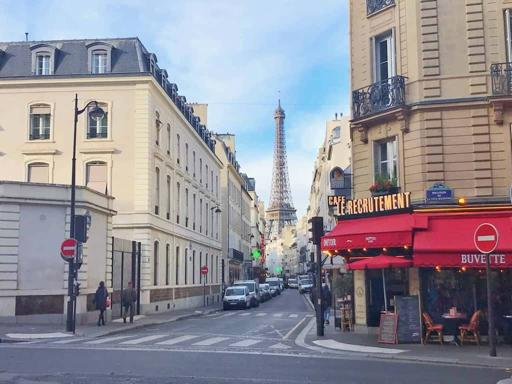

In [8]:
# let's first show the input image
pil_img

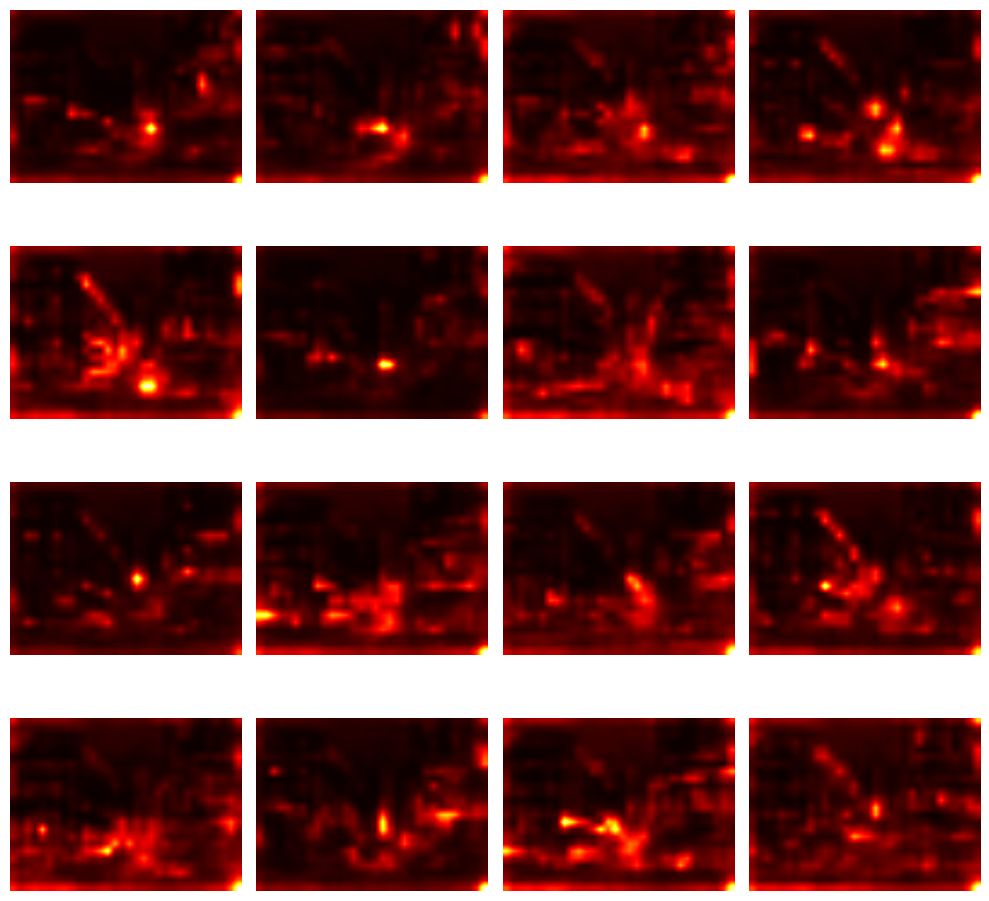

In [15]:
visualize_heatmaps(boq_block_attn1[:16]) # visualize the first 16 attention maps of the first BoQ block

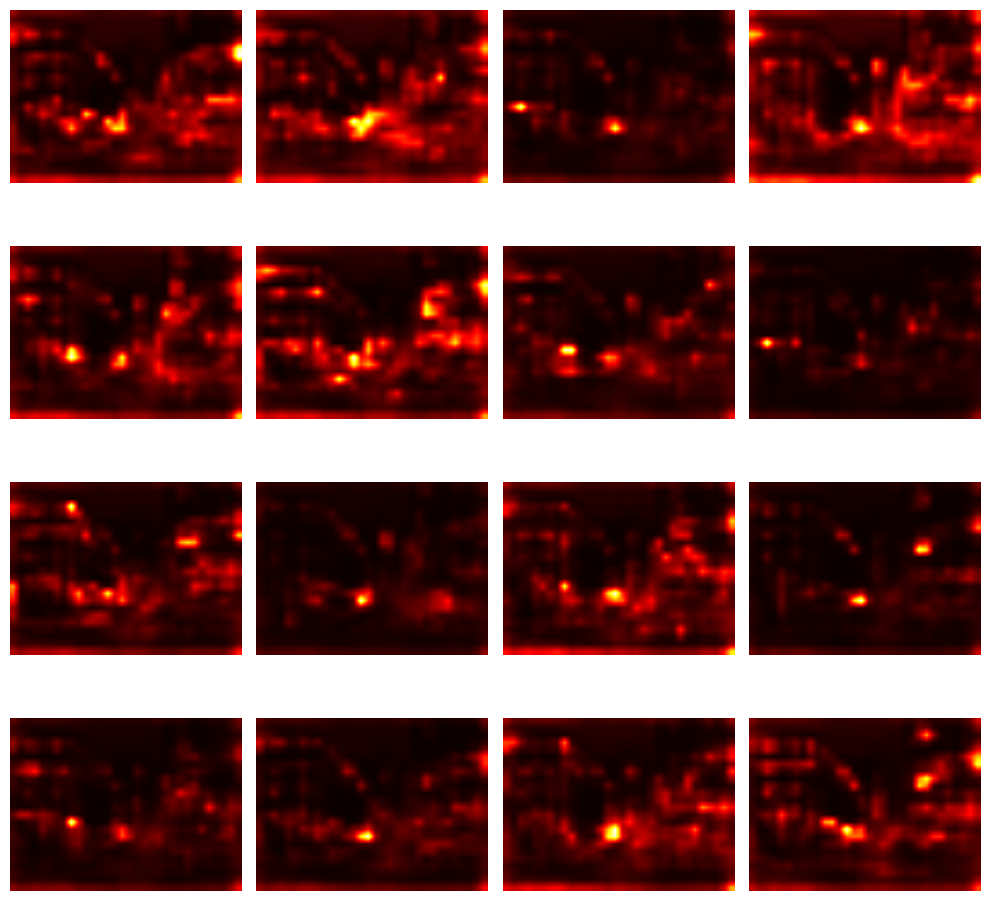

In [ ]:
visualize_heatmaps(boq_block_attn2[:16]) # visualize the first 16 attention maps of the second BoQ block